In [11]:
import pickle
import os
import time

import numpy as np
import pandas as pd
import scipy as sp

from numpy import linalg as LA

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD

from scipy import optimize
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import gc

Pipeline and OLS Benchmark

In [12]:
fname = "yield.pkl"
raw_text_dataset = pd.read_pickle( fname )
raw_text_dataset.head(5)

,id,type,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,...,duration_last1,duration_last2,duration_last3,duration_last4,duration_last5,duration_last6,duration_last7,duration_last8,duration_last9,duration_last10
0,1,train,1.0,128.596,11.316404,5.95,26.031126,0,1.731,120000,...,35.642227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,train,1.0,126.673,8.763446,5.95,26.016697,0,30.518,85000,...,35.728989,35.642227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,train,1.0,126.880,6.499730,5.95,26.008760,0,4.424,4200000,...,36.233816,35.728989,35.642227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,train,1.0,126.362,0.865854,5.95,26.008619,0,43.059,5000001,...,36.159652,36.233816,35.728989,35.642227,NaN,NaN,NaN,NaN,NaN,NaN
4,5,train,1.0,124.918,11.938543,5.95,25.981840,0,6.332,10000,...,36.305280,36.159652,36.233816,35.728989,35.642227,NaN,NaN,NaN,NaN,NaN


In [13]:
#add RPD column
raw_text_dataset['RPD'] = (raw_text_dataset['trade_price'] - raw_text_dataset['curve_based_price']) / raw_text_dataset['curve_based_price']

In [14]:
#test and train datasets
train = raw_text_dataset[raw_text_dataset['type'] == 'train'].drop('type', axis=1)
test  = raw_text_dataset[raw_text_dataset['type'] == 'test'].drop('type',axis=1)
del raw_text_dataset

In [15]:
#data preserved if NaN removed
train.dropna(subset=['trade_price_last10','curve_based_price_last10']).describe()['id'][0]/train.describe()['id'][0]

0.9768329491607205

In [16]:
#adjust train to drop NaN
train = train.dropna(subset=['trade_price_last10','curve_based_price_last10'])
#test = test.dropna(subset=['trade_price_last10','curve_based_price_last10'])

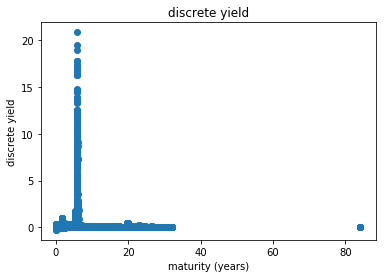

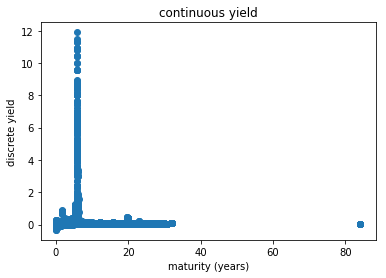

In [7]:
#maturity * yield for entire training dataset
plt.figure()
plt.scatter(train['time_to_maturity'], train['yield_discrete'])
plt.title('discrete yield')
plt.xlabel('maturity (years)')
plt.ylabel('discrete yield')

plt.figure()
plt.scatter(train['time_to_maturity'], train['yield'])
plt.title('continuous yield')
plt.xlabel('maturity (years)')
plt.ylabel('discrete yield')
plt.show()
plt.close()

In [ ]:
#feature histograms
path = 'hist/'
for i in train.columns:
    if i == 'type': continue
    train.hist(column = str(i), bins=100)
    plt.savefig(path + str(i) + '.png')
    plt.close()
    
gc.collect()

--- Pipeline and Baseline model

In [17]:
ommit = ('id','type','bond_id','trade_price')
# Create a class to select numerical columns
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, ommit):
        self.ommit = ommit
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        attribute_names = [i for i in list(X.columns) if i not in ommit]
        return X[attribute_names].values

#computes condition number of X
class ConditionNumber(BaseEstimator, TransformerMixin):
    def fit(self,X, y=None): return self
    def transform(self, X):
        return LA.cond(X)

#pre processes data and computes condition number
cond_pipe  = Pipeline([        
        ('selector', DataFrameSelector(ommit)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ('cond_num', ConditionNumber())
    ])

#pre processes data for regression
full_pipeline = Pipeline([        
        ('selector', DataFrameSelector(ommit)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])

def create_full_pipeline_with_predictor(predictor):
    pipe = Pipeline([
        ("preparation", full_pipeline),
        ("linear", predictor)
    ])
    return pipe

def run_describe_predictors(predictors, X, y):
    res = pd.DataFrame()
    for name, predictor in predictors.items():
        print(name)
        pipe = create_full_pipeline_with_predictor(predictor)
        scores = cross_val_score(pipe, X, y, scoring="neg_mean_squared_error", cv=10) #10-fold cross-validation
        res[str(name)] = pd.Series(scores).describe()
    return res

Constructing baseline model

In [18]:
#drop trade price and curve based price columns because of RPD
X = train.drop(['RPD', 'trade_price', 'curve_based_price'],axis=1)
y = train['RPD']

In [19]:
#condition number
base_cond = cond_pipe.fit_transform(X)
print(base_cond)

310.251591466


In [20]:
predictors = {'Linear Regression':LinearRegression()}
res = run_describe_predictors(predictors, X, y)
print(res)
model_stats_df = res.copy()

Linear Regression
       Linear Regression
count          10.000000
mean           -0.000357
std             0.001051
min            -0.003349
25%            -0.000048
50%            -0.000015
75%            -0.000012
max            -0.000008


In [ ]:
#Grid search ridge
predictor = Ridge()
param_grid = [
    # try varying the penalty and tolerance
    {
        'alpha': [0.01, 14000, 15000, 16000],
    },
  ]
grid_search = GridSearchCV(predictor, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs = 1)
grid_search.fit(full_pipeline.fit_transform(X), y)
grid_search.best_params_

In [16]:
predictors = {'Ridge':Ridge(alpha = 1)} #-.000569
res = run_describe_predictors(predictors, X, y)
print(res)
model_stats_df = model_stats_df.join(res)

Ridge
           Ridge
count  10.000000
mean   -0.000321
std     0.000963
min    -0.003062
25%    -0.000038
50%    -0.000007
75%    -0.000003
max    -0.000001


In [32]:
#Grid search elastic net
predictor = ElasticNet(alpha = 0.01,random_state=0)
param_grid = [
    # try varying the ll_ratio and tolerance
    {
        'l1_ratio': [ 0.125, 0.25, 0.5, 0.75, 0.875],
    },
  ]
grid_search = GridSearchCV(predictor, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs = 1)
grid_search.fit(full_pipeline.fit_transform(X), y)
grid_search.best_params_

{'l1_ratio': 0.125}

In [34]:
predictors = {'Elastic Net': ElasticNet(alpha = 0.01, l1_ratio = grid_search.best_params_['l1_ratio'])}
res = run_describe_predictors(predictors, X, y)
print(res)
model_stats_df = model_stats_df.join(res) 

Elastic Net
       Elastic Net
count    10.000000
mean     -0.000241
std       0.000166
min      -0.000695
25%      -0.000246
50%      -0.000195
75%      -0.000153
max      -0.000134


Linear regression has the lowest MSE, so we will use it as our baseline.

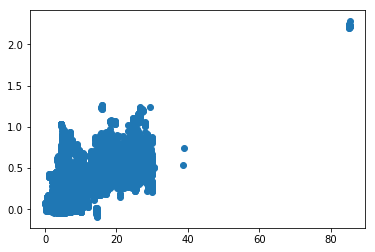

4511

In [132]:
#make a prediction using the benchmark
model = create_full_pipeline_with_predictor(LinearRegression())
reg = model.fit(X,y)
base_predict = reg.predict(test.drop('RPD',axis=1))

plt.figure()
plt.scatter(test['time_to_maturity'],base_predict)
plt.show()
plt.close()

gc.collect()

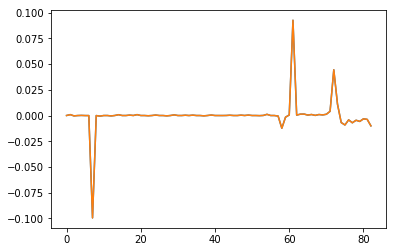

In [120]:
plt.plot(reg.named_steps['linear'].coef_ )
plt.show()

In [177]:
aux=(reg.named_steps['linear'].coef_ < -0.015)
np.where(aux==True)


(array([7], dtype=int64),)

In [181]:
list(X)[61],list(X)[72],list(X)[7]

('yield', 'yield_discrete8', 'reporting_delay')

In [191]:
list(X)

['id',
 'bond_id',
 'trade_price',
 'weight',
 'current_coupon',
 'time_to_maturity',
 'is_callable',
 'reporting_delay',
 'trade_size',
 'trade_type',
 'curve_based_price',
 'received_time_diff_last1',
 'trade_price_last1',
 'trade_size_last1',
 'trade_type_last1',
 'curve_based_price_last1',
 'received_time_diff_last2',
 'trade_price_last2',
 'trade_size_last2',
 'trade_type_last2',
 'curve_based_price_last2',
 'received_time_diff_last3',
 'trade_price_last3',
 'trade_size_last3',
 'trade_type_last3',
 'curve_based_price_last3',
 'received_time_diff_last4',
 'trade_price_last4',
 'trade_size_last4',
 'trade_type_last4',
 'curve_based_price_last4',
 'received_time_diff_last5',
 'trade_price_last5',
 'trade_size_last5',
 'trade_type_last5',
 'curve_based_price_last5',
 'received_time_diff_last6',
 'trade_price_last6',
 'trade_size_last6',
 'trade_type_last6',
 'curve_based_price_last6',
 'received_time_diff_last7',
 'trade_price_last7',
 'trade_size_last7',
 'trade_type_last7',
 'curve

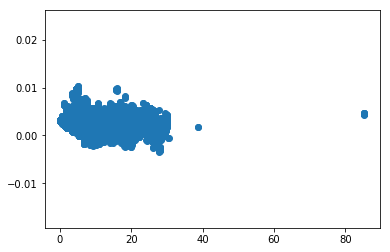

4466

In [124]:
model = create_full_pipeline_with_predictor(ElasticNet(alpha = 0.01, l1_ratio = 0.125))
reg = model.fit(X,y)
base_predict = reg.predict(test.drop('RPD',axis=1))

plt.figure()
plt.scatter(test['time_to_maturity'],base_predict)
plt.show()
plt.close()

gc.collect()

In [130]:
reg.named_steps['linear'].coef_ 

array([ -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         1.11619262e-05,  -1.09893623e-03,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,

Bond feature aggregations

Try it without level dependent data

In [41]:
level_cols = ['trade_price', 'current_coupon', 'trade_size', 'curve_based_price',
        'trade_price_last1', 'trade_size_last1', 'trade_type_last1',
       'curve_based_price_last1', 'received_time_diff_last2',
       'trade_price_last2', 'trade_size_last2', 'trade_type_last2',
       'curve_based_price_last2', 'received_time_diff_last3',
       'trade_price_last3', 'trade_size_last3', 'trade_type_last3',
       'curve_based_price_last3', 'received_time_diff_last4',
       'trade_price_last4', 'trade_size_last4', 'trade_type_last4',
       'curve_based_price_last4', 'received_time_diff_last5',
       'trade_price_last5', 'trade_size_last5', 'trade_type_last5',
       'curve_based_price_last5', 'received_time_diff_last6',
       'trade_price_last6', 'trade_size_last6', 'trade_type_last6',
       'curve_based_price_last6', 'received_time_diff_last7',
       'trade_price_last7', 'trade_size_last7', 'trade_type_last7',
       'curve_based_price_last7', 'received_time_diff_last8',
       'trade_price_last8', 'trade_size_last8', 'trade_type_last8',
       'curve_based_price_last8', 'received_time_diff_last9',
       'trade_price_last9', 'trade_size_last9', 'trade_type_last9',
       'curve_based_price_last9', 'received_time_diff_last10',
       'trade_price_last10', 'trade_size_last10', 'trade_type_last10',
       'curve_based_price_last10']
X_leveless = X.drop(level_cols,axis=1)

predictors = {'OLS Level-less':LinearRegression()}
res = run_describe_predictors(predictors, X_leveless, y)
print(res)

model_stats_df = model_stats_df.join(res)
gc.collect()

OLS Level-less
       OLS Level-less
count       10.000000
mean        -0.002699
std          0.008049
min         -0.025606
25%         -0.000196
50%         -0.000152
75%         -0.000127
max         -0.000110


135

Try it without past trades.

In [42]:
past_cols = ['received_time_diff_last1',
       'trade_price_last1', 'trade_size_last1', 'trade_type_last1',
       'curve_based_price_last1', 'received_time_diff_last2',
       'trade_price_last2', 'trade_size_last2', 'trade_type_last2',
       'curve_based_price_last2', 'received_time_diff_last3',
       'trade_price_last3', 'trade_size_last3', 'trade_type_last3',
       'curve_based_price_last3', 'received_time_diff_last4',
       'trade_price_last4', 'trade_size_last4', 'trade_type_last4',
       'curve_based_price_last4', 'received_time_diff_last5',
       'trade_price_last5', 'trade_size_last5', 'trade_type_last5',
       'curve_based_price_last5', 'received_time_diff_last6',
       'trade_price_last6', 'trade_size_last6', 'trade_type_last6',
       'curve_based_price_last6', 'received_time_diff_last7',
       'trade_price_last7', 'trade_size_last7', 'trade_type_last7',
       'curve_based_price_last7', 'received_time_diff_last8',
       'trade_price_last8', 'trade_size_last8', 'trade_type_last8',
       'curve_based_price_last8', 'received_time_diff_last9',
       'trade_price_last9', 'trade_size_last9', 'trade_type_last9',
       'curve_based_price_last9', 'received_time_diff_last10',
       'trade_price_last10', 'trade_size_last10', 'trade_type_last10',
       'curve_based_price_last10']
X_pastless = X.drop(past_cols,axis=1)

In [44]:
predictors = {'OLS Past-less':LinearRegression()}
res = run_describe_predictors(predictors, X_pastless, y)
print(res)
model_stats_df = model_stats_df.join(res)


OLS Past-less
       OLS Past-less
count      10.000000
mean       -0.000219
std         0.000643
min        -0.002049
25%        -0.000037
50%        -0.000007
75%        -0.000003
max        -0.000001


Regress with liquidity category

In [45]:
#trade_size
result=[]
liq_aux = X.groupby('bond_id')['trade_size'].sum()
liq = (liq_aux> liq_aux.median()).astype(int).to_frame()
result = X.join(liq,on='bond_id',rsuffix= '_liquidity')
X_liq = result.copy()

In [46]:
#change in condition number
liq_cond = cond_pipe.fit_transform(X_liq)
print(base_cond - liq_cond)

-0.0158258349709


In [47]:
predictors = {'OLS Liquidity':LinearRegression()}
res = run_describe_predictors(predictors, X_liq, y)
print(res)

model_stats_df = model_stats_df.join(res)
gc.collect()

OLS Liquidity
       OLS Liquidity
count      10.000000
mean       -0.000321
std         0.000963
min        -0.003061
25%        -0.000038
50%        -0.000007
75%        -0.000003
max        -0.000001


276

Regress with trade frequency category

In [48]:
#frequency
freq=train['bond_id'].value_counts().to_frame()
freq['freq'] = pd.qcut(freq,3,labels=False)
result = result.join(freq, on='bond_id',rsuffix='_frequency')
del result['bond_id_frequency']
X_freq = result.drop('trade_size_liquidity', axis=1)

In [49]:
#change in condition number
freq_cond = cond_pipe.fit_transform(X_freq)
print(base_cond - freq_cond)

-0.49551046597


In [50]:
predictors = {'OLS Frequency':LinearRegression()}
res = run_describe_predictors(predictors, X_freq, y)
print(res)

model_stats_df = model_stats_df.join(res)
gc.collect()

OLS Frequency
       OLS Frequency
count      10.000000
mean       -0.000321
std         0.000963
min        -0.003061
25%        -0.000038
50%        -0.000007
75%        -0.000003
max        -0.000001


339

Regress with price volatility category

In [51]:
#volatile 
aux_col = [col for col in result.columns if 'trade_price_' in col]
result['vol'] = (result[aux_col].std(ddof=0,axis=1)>0.1).astype(int)
X_vol = result.drop('freq',axis=1)

In [52]:
#change in condition number
vol_cond = cond_pipe.fit_transform(X_vol)
print(base_cond - vol_cond)

-0.0257588709457


In [53]:
predictors = {'OLS Volatility':LinearRegression()}
res = run_describe_predictors(predictors, X_vol, y)
print(res)

model_stats_df = model_stats_df.join(res)
gc.collect()

OLS Volatility
       OLS Volatility
count       10.000000
mean        -0.000321
std          0.000964
min         -0.003063
25%         -0.000038
50%         -0.000007
75%         -0.000003
max         -0.000001


326

Callable vs non-callable

In [54]:
#non callable bonds
train_no_callable = train[train['is_callable'] != 1]

#callable bonds
train_is_callable = train[train['is_callable'] == 1]

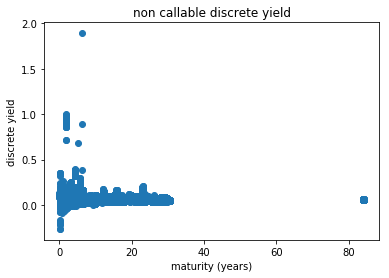

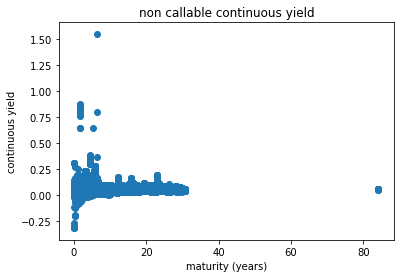

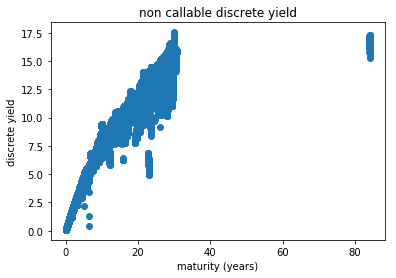

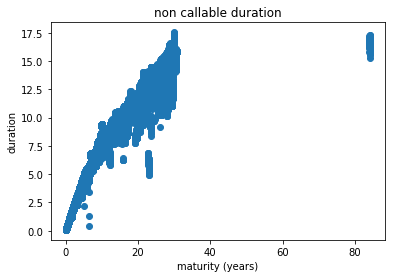

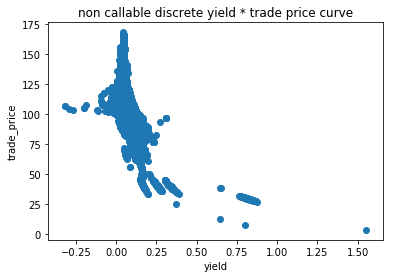

In [55]:
#maturity * yield for non callable bonds
plt.figure()
plt.scatter(train_no_callable['time_to_maturity'], train_no_callable['yield_discrete'])
plt.title('non callable discrete yield')
plt.xlabel('maturity (years)')
plt.ylabel('discrete yield')

plt.figure()
plt.scatter(train_no_callable['time_to_maturity'], train_no_callable['yield'])
plt.title('non callable continuous yield')
plt.xlabel('maturity (years)')
plt.ylabel('continuous yield')

#maturity * duration for non callable bonds
plt.figure()
plt.scatter(train_no_callable['time_to_maturity'], train_no_callable['duration'])
plt.title('non callable discrete yield')
plt.xlabel('maturity (years)')
plt.ylabel('discrete yield')

plt.figure()
plt.scatter(train_no_callable['time_to_maturity'], train_no_callable['duration'])
plt.title('non callable duration')
plt.xlabel('maturity (years)')
plt.ylabel('duration')

#yield * price
plt.figure()
plt.scatter(train_no_callable['yield'], train_no_callable['trade_price'])
plt.title('non callable discrete yield * trade price curve')
plt.xlabel('yield')
plt.ylabel('trade_price')

plt.show()
plt.close()

In [56]:
X_no_callable = train_no_callable.drop('RPD', axis=1)
y_no_callable = train_no_callable['RPD']

In [57]:
#change in condition number
no_callable_cond = cond_pipe.fit_transform(X_no_callable)
print(base_cond - no_callable_cond)

-8.53000509527e+16


In [58]:
predictors = {'OLS Non-callable':LinearRegression()}
res = run_describe_predictors(predictors, X_no_callable, y_no_callable)
print(res)
model_stats_df = model_stats_df.join(res)

OLS Non-callable
       OLS Non-callable
count      1.000000e+01
mean      -9.481099e-06
std        1.506061e-05
min       -5.008184e-05
25%       -9.859415e-06
50%       -2.924783e-06
75%       -1.886705e-06
max       -7.847022e-07


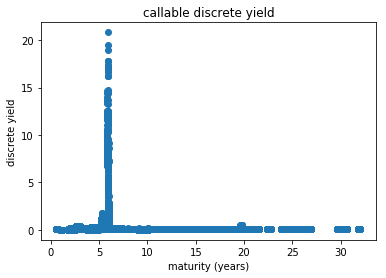

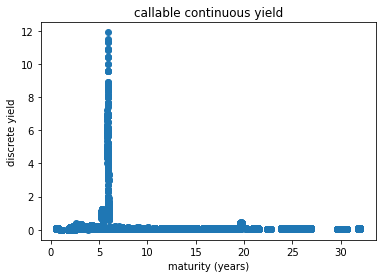

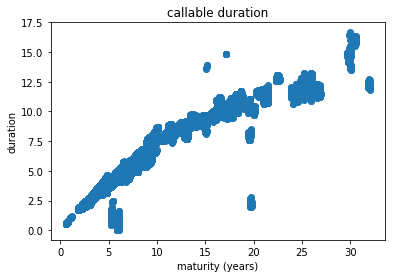

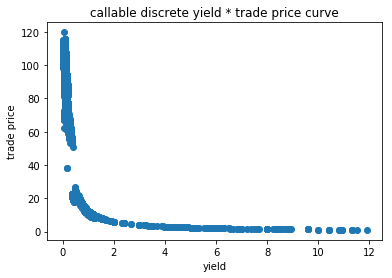

In [59]:
#model_stats_df = model_stats_df.add(res)
gc.collect()

#maturity * yield for callable bonds (note weird yields around 6 year maturity)
plt.figure()
plt.scatter(train_is_callable['time_to_maturity'], train_is_callable['yield_discrete'])
plt.title('callable discrete yield')
plt.xlabel('maturity (years)')
plt.ylabel('discrete yield')

plt.figure()
plt.scatter(train_is_callable['time_to_maturity'], train_is_callable['yield'])
plt.title('callable continuous yield')
plt.xlabel('maturity (years)')
plt.ylabel('discrete yield')

#maturity * duration
plt.figure()
plt.scatter(train_is_callable['time_to_maturity'], train_is_callable['duration'])
plt.title('callable duration')
plt.xlabel('maturity (years)')
plt.ylabel('duration')

#yield * price
plt.figure()
plt.scatter(train_is_callable['yield'], train_is_callable['trade_price'])
plt.title('callable discrete yield * trade price curve')
plt.xlabel('yield')
plt.ylabel('trade price')


plt.show()
plt.close()

In [60]:
X_is_callable = train_is_callable.drop('RPD', axis=1)
y_is_callable = train_is_callable['RPD']

In [61]:
#change in condition number
is_callable_cond = cond_pipe.fit_transform(X_is_callable)
print(base_cond - is_callable_cond)

-3.89769052118e+16


In [62]:
predictors = {'OLS Callable':LinearRegression()}
res = run_describe_predictors(predictors, X_is_callable, y_is_callable)

print(res)
model_stats_df = model_stats_df.join(res)

OLS Callable
       OLS Callable
count     10.000000
mean      -0.016035
std        0.050471
min       -0.159677
25%       -0.000050
50%       -0.000031
75%       -0.000008
max       -0.000003


Yield categorical variable

In [63]:
#categorizes bonds in  X into n_buckets evenly distributed buckets by discrete yield
def bucket(col, n_buckets):
    step = 1/n_buckets
    buckets = []

    quantiles = [col.quantile(i) for i in np.arange(0, 1+step, step)]
    
    bucket = []
    for i in range (0, col.shape[0]):
        for j in range(0,n_buckets):
            if quantiles[j] <= col[i] <= quantiles[j+1]:
                buckets.append(j)
                continue
        
    return bucket

In [64]:
train['yield_discrete'].isnull().sum()

0

In [65]:
#five buckets
b = pd.qcut(train['yield_discrete'],5,labels=False)
X_yield = train.drop('RPD',axis=1)
X_yield['yield_bucket'] = b

In [66]:
#change in condition number
yield_cond = cond_pipe.fit_transform(X_yield)
print(base_cond - yield_cond)

-2.75768192985


In [67]:
predictor = Ridge()
param_grid = [
    # try varying the penalty and tolerance
    {
        'alpha': [1, 2, 3, 4, 5,10,50,100,200],
    },
  ]
grid_search = GridSearchCV(predictor, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                            n_jobs = -1)
grid_search.fit(full_pipeline.fit_transform(X_yield), y)
grid_search.best_params_

{'alpha': 200}

In [68]:
predictors = {'OLS Yield':LinearRegression()}
res = run_describe_predictors(predictors, X_yield, y)
print(res)

model_stats_df = model_stats_df.join(res)
gc.collect()

OLS Yield
       OLS Yield
count  10.000000
mean   -0.000321
std     0.000963
min    -0.003060
25%    -0.000038
50%    -0.000007
75%    -0.000003
max    -0.000001


202

Trade price to curve based price discrepancy categorical variable

In [69]:
discrepancy = train['trade_price'] - train['curve_based_price']
b = pd.qcut(discrepancy,5,labels=False)
X_disc = X.copy()
X_disc['price discrepancy'] = b

In [70]:
#change in condition number
disc_cond = cond_pipe.fit_transform(X_disc)
print(base_cond - disc_cond)

-0.273249559074


In [71]:
predictors = {'OLS Discrepancy':LinearRegression()}
res = run_describe_predictors(predictors, X_disc, y)
print(res)
model_stats_df = model_stats_df.join(res)

OLS Discrepancy
       OLS Discrepancy
count        10.000000
mean         -0.000319
std           0.000959
min          -0.003048
25%          -0.000038
50%          -0.000007
75%          -0.000003
max          -0.000001


Duration categorical variable

In [72]:
gc.collect()

274

In [73]:
b=[]
b = pd.qcut(X['duration'],5,labels=False)
X_dur = X.copy()
X_dur['duration bucket'] = b

In [74]:
#change in condition number
dur_cond = cond_pipe.fit_transform(X_dur)
print(base_cond - dur_cond)


-1.17036572363


In [75]:
predictors = {'OLS Duration bucket':LinearRegression()}
res = run_describe_predictors(predictors, X_dur, y)
print(res)
model_stats_df = model_stats_df.join(res)


OLS Duration bucket
       OLS Duration bucket
count            10.000000
mean             -0.000321
std               0.000964
min              -0.003064
25%              -0.000038
50%              -0.000007
75%              -0.000003
max              -0.000001


20 component truncated SVD

In [76]:
#add truncated svd to pipeline
svd_full_pipeline = Pipeline([        
        ('selector', DataFrameSelector(ommit)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ('trunc_svd', TruncatedSVD(n_components=20))
    ])

svd_cond_pipeline = Pipeline([        
        ('selector', DataFrameSelector(ommit)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ('trunc_svd', TruncatedSVD(n_components=20)),
        ('cond_num', ConditionNumber())
    ])

def svd_create_full_pipeline_with_predictor(predictor):
    pipe = Pipeline([
        ("preparation", svd_full_pipeline),
        ("linear", predictor)
    ])
    return pipe

def svd_run_describe_predictors(predictors, X, y):
    res = pd.DataFrame()
    for name, predictor in predictors.items():
        pipe = svd_create_full_pipeline_with_predictor(predictor)
        scores = cross_val_score(pipe, X, y,scoring='neg_mean_squared_error', cv=10) #10-fold cross-validation
        print(pd.Series(scores).describe())
        print('')
        res[str(name)] = pd.Series(scores).describe()
    return res

In [77]:
X_all = train.drop(['RPD'],axis=1)
X_all['trade_size_liquidity'] = X_liq['trade_size_liquidity']
X_all['freq']                 = X_freq['freq']
X_all['vol']                  = X_vol['vol']
X_all['price_discrepancy']    = X_disc['price discrepancy']
X_all['duration_bucket']      = X_dur['duration bucket'] 
X_all['yield_bucket']         = X_yield['yield_bucket']
del X_liq; del X_freq; del X_vol; del X_disc; del X_dur; del X_yield
gc.collect()

297

In [78]:
predictors = {'OLS Truncated SVD':LinearRegression()}
res = svd_run_describe_predictors(predictors, X_all, y)
model_stats_df = model_stats_df.join(res)

count    10.000000
mean     -0.000170
std       0.000165
min      -0.000627
25%      -0.000164
50%      -0.000112
75%      -0.000089
max      -0.000077
dtype: float64



In [192]:
#make a prediction using the benchmark
model = svd_create_full_pipeline_with_predictor(LinearRegression())
reg = model.fit(X_all,y)
base_predict = reg.predict(test.drop('RPD',axis=1))

plt.figure()
plt.scatter(test['time_to_maturity'],base_predict)
plt.show()
plt.close()


ValueError: X has 83 features per sample, expected 89

Choose condition number that results in a reasonable degree of multicollinearity (i.e. condition number <=30)

In [80]:
trunc_cond = svd_cond_pipeline.fit_transform(X_all)
print(trunc_cond)

5.35986518391


for i in range(10,len(X_all.columns)-10,10):
    print(str(i) + ' components')
    svd_cond_pipeline.set_params(trunc_svd__n_components=i)
    print(svd_cond_pipeline.fit_transform(X_all))

50 components achieves a desirable amount of collinearity, so let's try truncated SVD regression with 50 components.

Generate best fitting model (all categorical variables that improve MSE and variance) and generate prediction. 

In [81]:
y_callable = train_is_callable['RPD']
y_non_callable = train_no_callable['RPD']

In [82]:
#best callable 
best_callable = train_is_callable.drop(past_cols,axis=1)
best_callable = best_callable.drop('RPD',axis=1)
discrepancy = best_callable['trade_price'] - best_callable['curve_based_price']
b = pd.qcut(discrepancy,5,labels=False)
best_callable['price discrepancy'] = b

#condition number (Suggests A LOT of multicollinearity)
print(cond_pipe.fit_transform(best_callable))

6.157291855e+15


In [83]:
#best non callable
best_non_callable = train_no_callable.drop(past_cols,axis=1)
best_non_callable = best_non_callable.drop('RPD',axis=1)

discrepancy = best_non_callable['trade_price'] - best_non_callable['curve_based_price']
b = pd.qcut(discrepancy,5,labels=False)
best_non_callable['price discrepancy'] = b

#condition number (Suggests A LOT of multicollinearity)
print(cond_pipe.fit_transform(best_non_callable))

1.15883215023e+16


In [84]:
#truncated non callable svd regression with 22 components
svd_cond_pipeline.set_params(trunc_svd__n_components=20)
predictors = {'OLS Truncated SVD non call 20':LinearRegression()}
res = svd_run_describe_predictors(predictors, best_non_callable, y_non_callable)
model_stats_df = model_stats_df.join(res)

count    10.000000
mean     -0.000062
std       0.000026
min      -0.000123
25%      -0.000074
50%      -0.000051
75%      -0.000048
max      -0.000041
dtype: float64



In [85]:
#truncated callable svd regression
svd_cond_pipeline.set_params(trunc_svd__n_components=20)
predictors = {'OLS Truncated SVD call 20':LinearRegression()}
res = svd_run_describe_predictors(predictors, best_callable, y_callable)
model_stats_df = model_stats_df.join(res)

count    10.000000
mean     -0.012981
std       0.040422
min      -0.128022
25%      -0.000277
50%      -0.000127
75%      -0.000088
max      -0.000055
dtype: float64



In [86]:
#linear regression non callable
predictors = {'Linear Regression best non callable':LinearRegression()}
res = run_describe_predictors(predictors, best_non_callable, y_non_callable)
print(res)

Linear Regression best non callable
       Linear Regression best non callable
count                         1.000000e+01
mean                         -9.278876e-06
std                           1.514328e-05
min                          -5.037776e-05
25%                          -7.682216e-06
50%                          -3.001133e-06
75%                          -1.880874e-06
max                          -7.940873e-07


In [87]:
#linear regression callable
predictors = {'Linear Regression best callable':LinearRegression()}
res = run_describe_predictors(predictors, best_callable, y_callable)
print(res)

Linear Regression best callable
       Linear Regression best callable
count                        10.000000
mean                         -0.014250
std                           0.044831
min                          -0.141842
25%                          -0.000044
50%                          -0.000021
75%                          -0.000009
max                          -0.000004


In [88]:
model_stats_df.to_csv('model_stats_elastic.csv')

In [92]:
model_stats_df.T

,count,mean,std,min,25%,50%,75%,max
Linear Regression,10.0,-0.000321,0.000963,-0.003061,-0.000038,-0.000007,-0.000003,-1.371397e-06
Ridge,10.0,-0.000321,0.000963,-0.003062,-0.000038,-0.000007,-0.000003,-1.366445e-06
Elastic Net,10.0,-0.000443,0.000161,-0.000681,-0.000251,-0.000199,-0.000156,-1.373426e-04
OLS Level-less,10.0,-0.002699,0.008049,-0.025606,-0.000196,-0.000152,-0.000127,-1.104274e-04
OLS Past-less,10.0,-0.000219,0.000643,-0.002049,-0.000037,-0.000007,-0.000003,-1.251652e-06
OLS Liquidity,10.0,-0.000321,0.000963,-0.003061,-0.000038,-0.000007,-0.000003,-1.373332e-06
OLS Frequency,10.0,-0.000321,0.000963,-0.003061,-0.000038,-0.000007,-0.000003,-1.359904e-06
OLS Volatility,10.0,-0.000321,0.000964,-0.003063,-0.000038,-0.000007,-0.000003,-1.376408e-06
OLS Non-callable,10.0,-0.000009,0.000015,-0.000050,-0.000010,-0.000003,-0.000002,-7.847022e-07
OLS Callable,10.0,-0.016035,0.050471,-0.159677,-0.000050,-0.000031,-0.000008,-2.843459e-06


Analysis of RPD

In [102]:
temp = X_all.copy()
temp['RPD'] = train.RPD

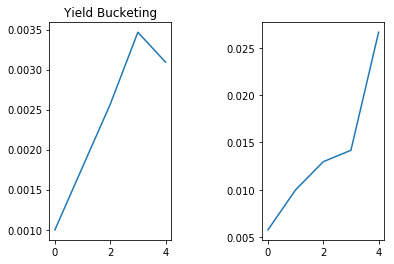

In [201]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(temp.groupby('yield_bucket')['RPD'].mean())
ax1.set_title('Yield Bucketing')
ax2.plot(temp.groupby('yield_bucket')['RPD'].std())
f.subplots_adjust(wspace=.75)
plt.show()

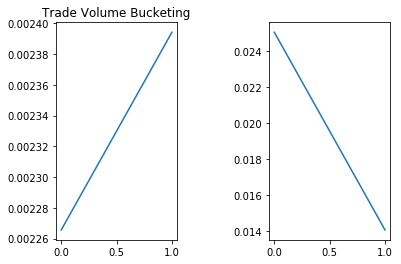

In [202]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(temp.groupby('trade_size_liquidity')['RPD'].mean())
ax1.set_title('Trade Volume Bucketing')
ax2.plot(temp.groupby('trade_size_liquidity')['RPD'].std())
f.subplots_adjust(wspace=.75)
plt.show()

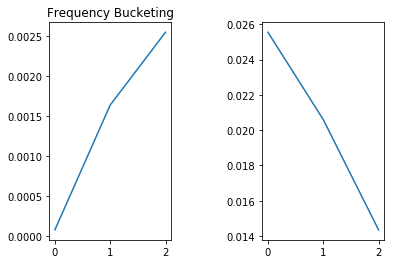

In [203]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(temp.groupby('freq')['RPD'].mean())
ax1.set_title('Frequency Bucketing')
ax2.plot(temp.groupby('freq')['RPD'].std())
f.subplots_adjust(wspace=.75)
plt.show()